# Assignemt 5

In [2]:
# %pip install flappy-bird-gymnasium

Note: you may need to restart the kernel to use updated packages.


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Neural Network

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# class QNetwork(nn.Module):
#      def __init__(self, input_dim, output_dim):
#          super(QNetwork, self).__init__()
#          self.l1 = nn.Linear(input_dim, 128)
#          self.l2 = nn.Linear(128, 64)
#          self.l3 = nn.Linear(64, 32)
#          self.l4 = nn.Linear(32, output_dim)
#          self.to(device)
#      def forward(self, x):
#        if x.dim() == 1:
#            x = x.unsqueeze(0)
#        x = x.to(device)
#        x = torch.relu(self.l1(x))
#        x = torch.relu(self.l2(x))
#        x = torch.relu(self.l3(x))
#        x = self.l4(x)
#        return x

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.l1 = nn.Linear(input_dim, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 32)
        self.l4 = nn.Linear(32, output_dim)

        nn.init.xavier_uniform_(self.l1.weight)
        nn.init.xavier_uniform_(self.l2.weight)
        nn.init.xavier_uniform_(self.l3.weight)
        nn.init.xavier_uniform_(self.l4.weight)
       

        self.to(device)

    def forward(self, x):
      if x.dim() == 1:
          x = x.unsqueeze(0)
      x = x.to(device)

      x = torch.relu(self.l1(x))
      x = torch.relu(self.l2(x))
      x = torch.relu(self.l3(x))
      x = self.l4(x)
      return x

cpu


## Agent

In [8]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class QLearningAgent:
    def __init__(self, input_dim, output_dim, gamma=0.9, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.00001,lr=0.00025,replay_buffer_capacity=50000):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_network = QNetwork(input_dim, output_dim)
        self.target_network = QNetwork(input_dim, output_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(capacity=replay_buffer_capacity)
        self.mode='train'
        self.steps=0

    def choose_action(self, state):
        if np.random.rand() < self.epsilon and self.mode=='train':
            return np.random.choice(self.output_dim)
        state_tensor = torch.FloatTensor(state).to(device)
        q_values = self.q_network(state_tensor)
        return torch.argmax(q_values).item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        batch = self.replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)


        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
          next_q_values = self.q_network(next_states).max(1)[0]
          target_q_values = rewards + self.gamma * next_q_values * (1 - dones)


        loss = nn.MSELoss()(q_values, target_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps+=1
        if self.steps % 100 == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon-=self.epsilon_decay

    def save(self, filepath):
        state = {
            'q_network_state_dict': self.q_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'epsilon_min': self.epsilon_min,
            'epsilon_decay': self.epsilon_decay,
        }
        torch.save(state, filepath)
        print(f"Agent saved to {filepath}")

    def load(self, filepath):
        state = torch.load(filepath)
        self.q_network.load_state_dict(state['q_network_state_dict'])
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer.load_state_dict(state['optimizer_state_dict'])
        self.epsilon = state['epsilon']
        self.epsilon_min = state['epsilon_min']
        self.epsilon_decay = state['epsilon_decay']
        print(f"Agent loaded from {filepath}")

## Training

In [9]:
from os import path
import matplotlib.pyplot as plt

def show_scores(scores,save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(scores, label="Score per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.title("Scores Obtained by Each Episode")
    plt.legend()
    plt.grid()
    if save_path:
      plt.savefig(path.join(save_path, "scores_plot.png"))

    plt.show()

In [10]:


# save_path="/content/drive/MyDrive/rn/agents"
save_path="D:\\rn\\Neural-Networks-Template-2024\\Lab11\\agents"


def train_agent(agent,env,num_episodes=1000,batch_size=100,skip_frames=2):
    best_average_score=0
    agent.mode='train'
    scores = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0
        done = False
        passed_pipe=False
        skip_counter = 0

        while not done:
            if skip_counter > 0:
              skip_counter-=1
              continue
            action = agent.choose_action(state)
            next_state, reward, done, _, info = env.step(action)
            if reward == 1:
              skip_counter = skip_frames
            agent.replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.train(batch_size)
        scores.append(total_reward)
        if (episode+1) % 100 == 0:
            print(f"Episode: {episode+1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")
        if (episode+1) % 1_000 == 0:
            agent.save(path.join(save_path, f"agent_2_{episode+1}.pth"))
            show_scores(scores,save_path)
            best_score,avg_Score=evaluate_agent(agent,env,num_episodes=100)
            print(f"Best Score: {best_score}, Average Score: {avg_Score}")
            if avg_Score>best_average_score:
              best_average_score=avg_Score
              agent.save(path.join(save_path, f"agent_2_best.pth"))




## Evaluation

In [11]:
def evaluate_agent(agent,env,num_episodes=100,detailed=False):
    agent.mode='eval'
    scores = []
    final_scores = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _, info = env.step(action)
            state = next_state
            total_reward += reward
        scores.append(total_reward)
        final_scores.append(info['score'])
        if detailed:
           print(f"Episode: {episode+1}, Total Reward: {total_reward}")
    best_score = max(scores)
    total_scores = sum(scores)
    agent.mode='train'
    if detailed:
      show_scores(scores)
      print(f"Best final score: {max(final_scores)}")
      print(f"Total final score: {sum(final_scores)}")
    return best_score,total_scores/len(scores)


## Solution

In [5]:
import gymnasium as gym
import flappy_bird_gymnasium
from typing import TypedDict

class Hyperparameters(TypedDict):
    gamma: float
    epsilon: float
    epsilon_min: float
    epsilon_decay: float
    learning_rate: float
    batch_size: int
    skip_frames:int
    episodes:int
    replay_buffer_capacity:int

hyperparameters=Hyperparameters(
    gamma=0.9,
    epsilon=1.0,
    epsilon_min=0.05,
    epsilon_decay=0.000003,
    learning_rate=0.0001,
    batch_size=128,
    skip_frames=2,
    episodes=10_000,
    replay_buffer_capacity=100_000
)

In [6]:


env = gym.make('FlappyBird-v0')

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
agent = QLearningAgent(input_dim, output_dim,gamma=hyperparameters['gamma'], epsilon=hyperparameters['epsilon'], epsilon_min=hyperparameters['epsilon_min'], epsilon_decay=hyperparameters['epsilon_decay'],lr=hyperparameters['learning_rate'],replay_buffer_capacity=hyperparameters['replay_buffer_capacity'])
train_agent(agent,env,num_episodes=hyperparameters['episodes'],batch_size=hyperparameters['batch_size'],skip_frames=hyperparameters['skip_frames'])



NameError: name 'gym' is not defined

C:\Users\Alex\AppData\Local\Temp\ipykernel_25868\3519866154.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filepath)
c:\Users\Alex\miniforge3\envs\3

Agent loaded from D:\rn\Neural-Networks-Template-2024\Lab11\agents\agent_best_3.pth
Episode: 1, Total Reward: 2.3999999999999986
Episode: 2, Total Reward: 6.7999999999999865
Episode: 3, Total Reward: 19.20000000000004
Episode: 4, Total Reward: 2.299999999999999
Episode: 5, Total Reward: 8.399999999999975
Episode: 6, Total Reward: 6.2999999999999865
Episode: 7, Total Reward: 27.000000000000135
Episode: 8, Total Reward: 10.599999999999977
Episode: 9, Total Reward: 17.90000000000001
Episode: 10, Total Reward: 34.70000000000021
Episode: 11, Total Reward: 1.300000000000002
Episode: 12, Total Reward: 28.90000000000016
Episode: 13, Total Reward: 19.600000000000072
Episode: 14, Total Reward: 1.300000000000002
Episode: 15, Total Reward: 5.399999999999989
Episode: 16, Total Reward: 19.200000000000035
Episode: 17, Total Reward: 6.499999999999986
Episode: 18, Total Reward: 5.499999999999988
Episode: 19, Total Reward: 7.599999999999982
Episode: 20, Total Reward: 2.299999999999999
Episode: 21, Total

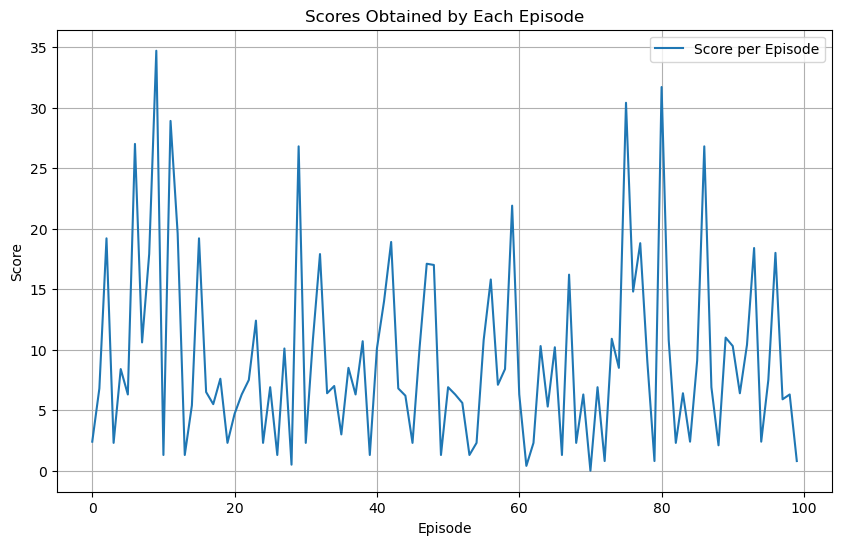

Best final score: 8
Total final score: 213


In [12]:

env = gym.make("FlappyBird-v0", render_mode="human",use_lidar=True)


input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
agent = QLearningAgent(input_dim, output_dim,gamma=hyperparameters['gamma'], epsilon=hyperparameters['epsilon'], epsilon_min=hyperparameters['epsilon_min'], epsilon_decay=hyperparameters['epsilon_decay'],lr=hyperparameters['learning_rate'],replay_buffer_capacity=hyperparameters['replay_buffer_capacity'])
agent.load(path.join(save_path, "agent_best_3.pth"))
evaluate_agent(agent,env,num_episodes=100,detailed=True)

env.close()
